<img src="https://storage.googleapis.com/pr-newsroom-wp/1/2023/12/Generic-FTR-headers_V10-1920x733.jpg" alt="Spotify App" style="width: 100%; height: auto;">

# Spotify App Review - PROG8245 Project



**Team 7 - Members**:
- Ponnu Peter, 9058740
- Madalina Tilvan, 9058215
- Jayavanti Wesley, 9019852


## Overview

This project focuses on analyzing user reviews for the Spotify application, using Natural Language Processing (NLP) techniques to classify the sentiment of user comments into three categories: positive, neutral, and negative.

In this notebook, we will:
- Preprocess the dataset using tokenization, stop-word removal, stemming/lemmatization, and handling text-specific challenges like emojis, hashtags, and slang.
- Explore different feature extraction techniques: TF-IDF, Word2Vec, and BERT embeddings, to transform text data into meaningful numerical representations.
- Determine the most effective embeddings technique to use for sentiment prediction.
- Build and evaluate a deep learning model to predict the sentiment of the reviews.

In [ ]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from gensim.models import Word2Vec

warnings.filterwarnings('ignore')

In [ ]:
print("CUDA Available:", torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0))

CUDA Available: True
GPU Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Madalina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Madalina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Madalina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Madalina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load the dataset
path = "dataset/reviews.csv"
df_spotify = pd.read_csv(path)
df_spotify

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
...,...,...,...,...,...
61589,2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
61591,2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't jus...,2,1,NaN


The dataset is already annotated with sentiment labels (`Rating` feature) which will be categorized as negative (1 or 2 stars), neutral (3 stars), and positive (4 or 5 stars).

## Data Preprocessing and EDA

In [ ]:
## check for empty values
df_spotify.isnull().sum()

Time_submitted        0
Review                0
Rating                0
Total_thumbsup        0
Reply             61378
dtype: int64

In [ ]:
df_spotify.isnull().mean() * 100

Time_submitted     0.000000
Review             0.000000
Rating             0.000000
Total_thumbsup     0.000000
Reply             99.649316
dtype: float64

Given that 99.65% of the values in the `Reply` column are missing, including this column into our analysis will result in a significant loss of information. This is why we will exclude it, along with `Time_submitted` and `Total_thumbsup`, as they are not essential to NLP focused analysis.

In [ ]:
df_spotify = df_spotify.drop(columns=['Time_submitted', 'Total_thumbsup', 'Reply'])

### Adding sentiment labels based on ratings

In [ ]:
def label_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df_spotify['Rating'] = df_spotify['Rating'].apply(label_sentiment)


### Distribution of rating

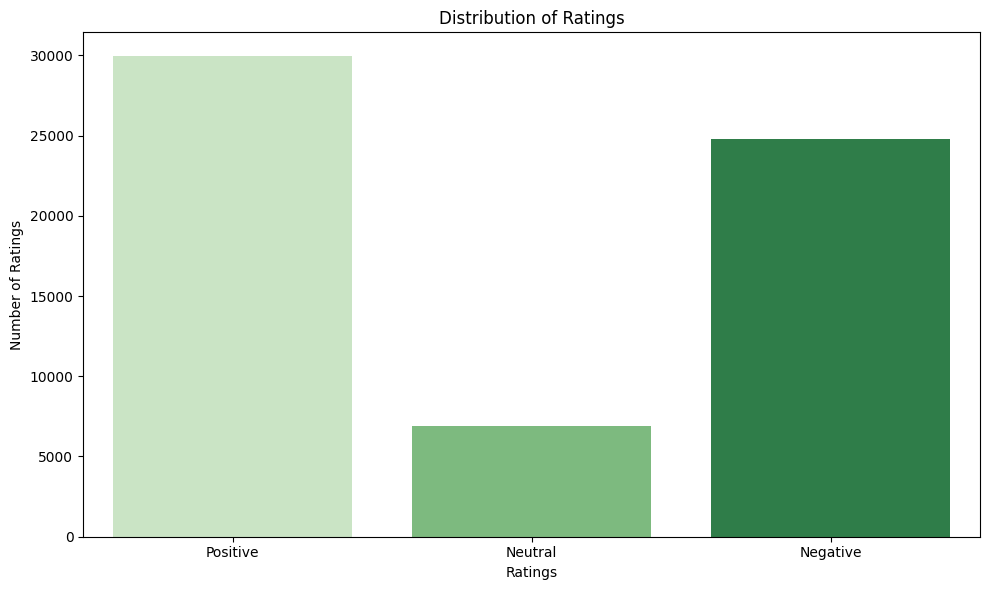

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df_spotify, order=['Positive', 'Neutral', 'Negative'], palette='Greens')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.show()

We can observe a clear imbalance across the three sentiment categories. The **Positive** category has the highest number of ratings, followed by **Negative**, with **Neutral** ratings being the least frequent. This suggests that users tend to give either Positive or Negative ratings, with a difference of only 5,000 between them. This imbalance could be an important factor to consider when training our model, as it might affect the sentiment prediction.

## Text Preprocessing

To ensure that all preprocessing steps are working correctly, we'll use two reviews from different categories:
- Review 1715 - Positive (contains numbers, emojis, and hashtags)
- Review 6628 - Negative (contains slang, numbers, and emojies)


In [ ]:
print(df_spotify['Review'][1715])
print()
print(df_spotify['Review'][6628])

After using over five(5) music 🎵 apps , this is one of many I give a five(5)+🌟🌟🌟🌟🌟🔥 In which I enjoy sharing With family and friends. Also , you can creat your Own playlist 🎧🎶🎵🎧 And share .... 🔝#1🎭✨✨👍

Tbh this app is insanely overated because whenever I try to play something it plays something else completely different and I cannot change it and without the premium subscription you can only skip 6 musics per hour 😐


### Tokenization

In [ ]:
df_spotify['Review'] = [word_tokenize(review) for review in df_spotify['Review']]

print("Tokenization:")
print(df_spotify['Review'][1715])
print(df_spotify['Review'][6628])

Tokenization:
['After', 'using', 'over', 'five', '(', '5', ')', 'music', '🎵', 'apps', ',', 'this', 'is', 'one', 'of', 'many', 'I', 'give', 'a', 'five', '(', '5', ')', '+🌟🌟🌟🌟🌟🔥', 'In', 'which', 'I', 'enjoy', 'sharing', 'With', 'family', 'and', 'friends', '.', 'Also', ',', 'you', 'can', 'creat', 'your', 'Own', 'playlist', '🎧🎶🎵🎧', 'And', 'share', '....', '🔝', '#', '1🎭✨✨👍']
['Tbh', 'this', 'app', 'is', 'insanely', 'overated', 'because', 'whenever', 'I', 'try', 'to', 'play', 'something', 'it', 'plays', 'something', 'else', 'completely', 'different', 'and', 'I', 'can', 'not', 'change', 'it', 'and', 'without', 'the', 'premium', 'subscription', 'you', 'can', 'only', 'skip', '6', 'musics', 'per', 'hour', '😐']


### Lemmatization and lowercasing

In [ ]:
print('Before lemmatization:')
print(df_spotify['Review'][1715])
print(df_spotify['Review'][6628])
print()

lemmatizer = WordNetLemmatizer()
df_spotify['Review'] = [
    [lemmatizer.lemmatize(word.lower()) for word in review] for review in df_spotify['Review']
]

print('After lemmatization:')
print(df_spotify['Review'][1715])
print(df_spotify['Review'][6628])


Before lemmatization:
['After', 'using', 'over', 'five', '(', '5', ')', 'music', '🎵', 'apps', ',', 'this', 'is', 'one', 'of', 'many', 'I', 'give', 'a', 'five', '(', '5', ')', '+🌟🌟🌟🌟🌟🔥', 'In', 'which', 'I', 'enjoy', 'sharing', 'With', 'family', 'and', 'friends', '.', 'Also', ',', 'you', 'can', 'creat', 'your', 'Own', 'playlist', '🎧🎶🎵🎧', 'And', 'share', '....', '🔝', '#', '1🎭✨✨👍']
['Tbh', 'this', 'app', 'is', 'insanely', 'overated', 'because', 'whenever', 'I', 'try', 'to', 'play', 'something', 'it', 'plays', 'something', 'else', 'completely', 'different', 'and', 'I', 'can', 'not', 'change', 'it', 'and', 'without', 'the', 'premium', 'subscription', 'you', 'can', 'only', 'skip', '6', 'musics', 'per', 'hour', '😐']

After lemmatization:
['after', 'using', 'over', 'five', '(', '5', ')', 'music', '🎵', 'apps', ',', 'this', 'is', 'one', 'of', 'many', 'i', 'give', 'a', 'five', '(', '5', ')', '+🌟🌟🌟🌟🌟🔥', 'in', 'which', 'i', 'enjoy', 'sharing', 'with', 'family', 'and', 'friend', '.', 'also', ',', 'yo

### Stopwords removal

In [ ]:
stop_words = set(stopwords.words('english'))
df_spotify['Review'] = [
    [word for word in review if word not in stop_words] for review in df_spotify['Review']
]

print('Stopwords removal:')
print(df_spotify['Review'][1715])
print(df_spotify['Review'][6628])


Stopwords removal:
['using', 'five', '(', '5', ')', 'music', '🎵', 'apps', ',', 'one', 'many', 'give', 'five', '(', '5', ')', '+🌟🌟🌟🌟🌟🔥', 'enjoy', 'sharing', 'family', 'friend', '.', 'also', ',', 'creat', 'playlist', '🎧🎶🎵🎧', 'share', '....', '🔝', '#', '1🎭✨✨👍']
['tbh', 'app', 'insanely', 'overated', 'whenever', 'try', 'play', 'something', 'play', 'something', 'else', 'completely', 'different', 'change', 'without', 'premium', 'subscription', 'skip', '6', 'music', 'per', 'hour', '😐']


### Removing special characters

#### • Handling hashtags

In [ ]:
def remove_hashtags(tokens):
    return [word[1:] if word.startswith('#') else word for word in tokens]
df_spotify['Review'] = [
    remove_hashtags(review) for review in df_spotify['Review']
]

print('Hashtags removal:')
print(df_spotify['Review'][1715])
print(df_spotify['Review'][6628])

Hashtags removal:
['using', 'five', '(', '5', ')', 'music', '🎵', 'apps', ',', 'one', 'many', 'give', 'five', '(', '5', ')', '+🌟🌟🌟🌟🌟🔥', 'enjoy', 'sharing', 'family', 'friend', '.', 'also', ',', 'creat', 'playlist', '🎧🎶🎵🎧', 'share', '....', '🔝', '', '1🎭✨✨👍']
['tbh', 'app', 'insanely', 'overated', 'whenever', 'try', 'play', 'something', 'play', 'something', 'else', 'completely', 'different', 'change', 'without', 'premium', 'subscription', 'skip', '6', 'music', 'per', 'hour', '😐']


- Handling emojis

In [ ]:
def remove_non_alphanumeric_tokens(tokens):
    return [token for token in tokens if token.isalnum()]

df_spotify['Review'] = [
    remove_non_alphanumeric_tokens(review) for review in df_spotify['Review']
]

print('Emoji removal:')
print(df_spotify['Review'][1715])
print(df_spotify['Review'][6628])

Emoji removal:
['using', 'five', '5', 'music', 'apps', 'one', 'many', 'give', 'five', '5', 'enjoy', 'sharing', 'family', 'friend', 'also', 'creat', 'playlist', 'share']
['tbh', 'app', 'insanely', 'overated', 'whenever', 'try', 'play', 'something', 'play', 'something', 'else', 'completely', 'different', 'change', 'without', 'premium', 'subscription', 'skip', '6', 'music', 'per', 'hour']


In [ ]:
def remove_non_ascii_tokens(tokens):
    return [token for token in tokens if token.isascii()]
cleaned_reviews = []

for tokens in df_spotify['Review']:
    cleaned_tokens = remove_non_ascii_tokens(tokens)
    cleaned_reviews.append(cleaned_tokens)
df_spotify['Review'] = cleaned_reviews

Check if any emojis are left

In [ ]:
non_ascii_tokens = []
for tokens in df_spotify['Review']:
    for token in tokens:
        if not token.isascii():  # Check if token is non-ASCII
            non_ascii_tokens.append(token)

# Show total and unique tokens
print(f"Total non-ASCII tokens: {len(non_ascii_tokens)}")
print(f"Unique non-ASCII tokens: {len(set(non_ascii_tokens))}")
print("Sample non-ASCII tokens:", list(set(non_ascii_tokens))[:20])


Total non-ASCII tokens: 0
Unique non-ASCII tokens: 0
Sample non-ASCII tokens: []


#### • Handling slang

In [ ]:
# Frequent slang dictionary
slang_dict = {
    "plz": "please",
    "pls": "please",
    "u": "you",
    "ur": "your",
    "lol": "laugh out loud",
    "brb": "be right back",
    "btw": "by the way",
    "idk": "I don't know",
    "omg": "oh my god",
    "tho": "though",
    "sick": "awesome",
    "bro": "friend",
    "vibe": "energy",
    "tbh": "to be honest",
    "woke": "socially aware",
    "chill": "relaxed",
    "lit": "exciting",
    "savage": "harsh",
    "bff": "best friend forever",
    "sus": "suspicious",
    "fam": "family",
    "gonna": "going to",
    "wanna": "want to",
}
slang_tokens = []

for tokens in df_spotify['Review']:
    for token in tokens:
        if token.lower() in slang_dict:
            slang_tokens.append(token.lower())

# Show results
print(f"Total slang tokens found: {len(slang_tokens)}")
print(f"Unique slang tokens: {set(slang_tokens)}")


Total slang tokens found: 4635
Unique slang tokens: {'pls', 'tbh', 'lit', 'chill', 'u', 'woke', 'bro', 'tho', 'bff', 'vibe', 'sick', 'savage', 'ur', 'plz', 'lol', 'omg', 'sus', 'btw', 'fam', 'idk'}


In [ ]:
slang_words = {'ur', 'idk', 'btw', 'omg', 'u', 'lol', 'tho'}            # List of slang words

def remove_slang(tokens):                                               # Function to remove slang tokens
    return [token for token in tokens if token not in slang_words]
df_spotify['Review'] = [
    remove_slang(review) for review in df_spotify['Review']             # Remove slang words from the 'Review' column without using apply
]


#### • Handling numbers

In [ ]:
# Function to remove tokens that contain both numbers
def remove_unwanted_tokens(tokens):
    clean_tokens = []
    for token in tokens:
        if any(char.isdigit() for char in token):
            continue 
        clean_tokens.append(token)
    return clean_tokens
df_spotify['Review'] = [
    remove_unwanted_tokens(review) for review in df_spotify['Review']
]

In [ ]:
print("Final cleaned reviews:")
print(df_spotify['Review'][1715])
print(df_spotify['Review'][6628])

Final cleaned reviews:
['using', 'five', 'music', 'apps', 'one', 'many', 'give', 'five', 'enjoy', 'sharing', 'family', 'friend', 'also', 'creat', 'playlist', 'share']
['tbh', 'app', 'insanely', 'overated', 'whenever', 'try', 'play', 'something', 'play', 'something', 'else', 'completely', 'different', 'change', 'without', 'premium', 'subscription', 'skip', 'music', 'per', 'hour']


## EDA

### Sentiment Word Frequency

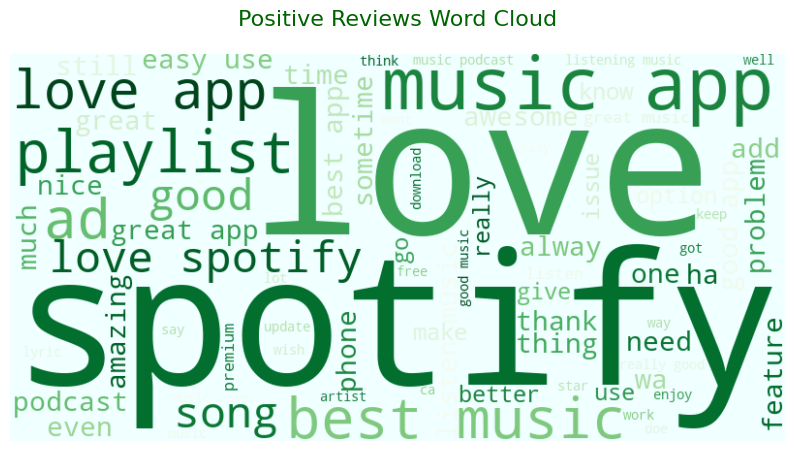

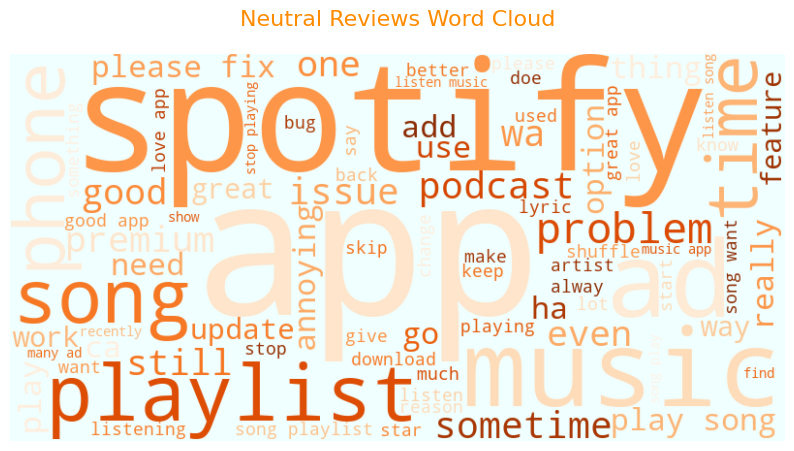

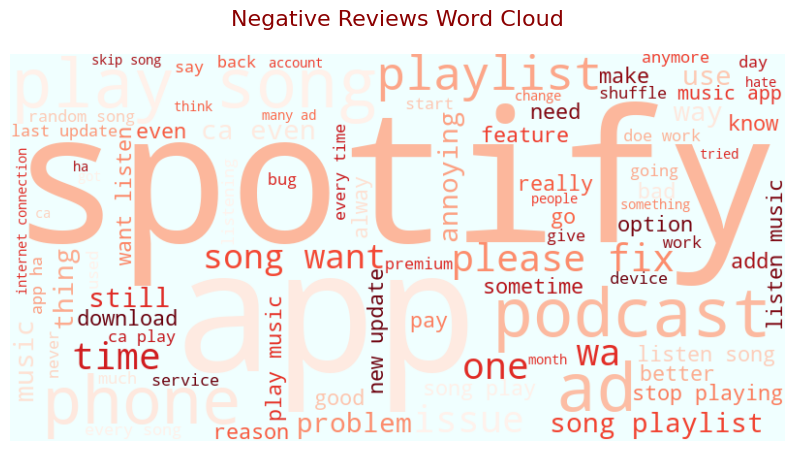

In [ ]:
positive_review = " ".join(df_spotify[df_spotify['Rating'] == 'Positive']['Review'].astype(str))
neutral_review = " ".join(df_spotify[df_spotify['Rating'] == 'Neutral']['Review'].astype(str))
negative_review = " ".join(df_spotify[df_spotify['Rating'] == 'Negative']['Review'].astype(str))

kwargs = dict(
    width=800, height=400, 
    background_color='#F0FFFF', 
    min_font_size=14,
    max_font_size=200,
    relative_scaling=0.2,
    regexp=r"[A-Za-z0-9]+"
)

plt.figure(figsize=(10, 6), facecolor='white')
wordcloud_positive = WordCloud(**kwargs, colormap="Greens_r").generate(positive_review)
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews Word Cloud", fontsize=16, color="darkgreen", pad=20)

plt.figure(figsize=(10, 6), facecolor='white')
wordcloud_neutral = WordCloud(**kwargs, colormap="Oranges_r").generate(neutral_review)
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis("off")
plt.title("Neutral Reviews Word Cloud", fontsize=16, color="darkorange", pad=20)

plt.figure(figsize=(10, 6), facecolor='white')
wordcloud_negative = WordCloud(**kwargs, colormap="Reds_r").generate(negative_review)
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews Word Cloud", fontsize=16, color="darkred", pad=20)

plt.show()

In [ ]:
def top10_words(text, wordcloud, sentiment):
    word = pd.DataFrame(wordcloud.process_text(''.join(text)).items()).sort_values(1, ascending=False)
    
    print(f'Top most frequent 10 {sentiment} words:\n')
    for i in range(10):
        item = word.iloc[i]
        print(item[0] + '\t\t ' + str(item[1]))
    print('\n')

In [ ]:
positive = df_spotify[df_spotify['Rating'] == 'Positive']['Review'].astype(str)
neutral = df_spotify[df_spotify['Rating'] == 'Positive']['Review'].astype(str)
negative = df_spotify[df_spotify['Rating'] == 'Positive']['Review'].astype(str)

# positive_review = " ".join(df_spotify[df_spotify['Rating'] == 'Positive']['Review'].astype(str))

top10_words(positive, wordcloud_positive, 'positive')
print("-"*50 + '\n')
top10_words(neutral, wordcloud_neutral, 'neutral')
print("-"*50 + '\n')
top10_words(negative, wordcloud_negative, 'negative')


Top most frequent 10 positive words:

love		 2772
spotify		 2521
music app		 2320
playlist		 1880
best music		 1599
ad		 1473
love app		 1446
love spotify		 1375
song		 1338
good		 1335


--------------------------------------------------

Top most frequent 10 neutral words:

love		 2772
spotify		 2521
music app		 2320
playlist		 1880
best music		 1599
ad		 1473
love app		 1446
love spotify		 1375
song		 1338
good		 1335


--------------------------------------------------

Top most frequent 10 negative words:

love		 2772
spotify		 2521
music app		 2320
playlist		 1880
best music		 1599
ad		 1473
love app		 1446
love spotify		 1375
song		 1338
good		 1335




## Feature Extraction

### 1. Classic Embeddings: TF-IDF

In [ ]:
df_spotify['Review_clean'] = df_spotify['Review'].apply(lambda x: ' '.join(x))

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_vectorizer.fit(df_spotify['Review_clean'])
X_tfidf = tfidf_vectorizer.transform(df_spotify['Review_clean']).toarray().astype(np.float32)

### 2. Static Embeddings: Word2Vec

In [ ]:
# Tokenize for Word2Vec
tokenized_reviews = [text.split() for text in df_spotify['Review_clean']]

# Train Word2Vec model
w2v_embedding = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

In [ ]:
# Function to average Word2Vec vectors for a review
def get_w2v_vector(tokens):
    valid_tokens = [token for token in tokens if token in w2v_embedding.wv]
    if not valid_tokens:
        return [0]*100
    return list(sum(w2v_embedding.wv[token] for token in valid_tokens) / len(valid_tokens))

In [ ]:
# Apply to all reviews
X_word2vec = [get_w2v_vector(tokens) for tokens in tokenized_reviews]
X_word2vec = np.array(X_word2vec)

### 3. Contextual Embeddings: BERT

In [ ]:
# Define device to run with GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load pre-trained BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_embedding = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_embedding.eval()  # Set model to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = bert_embedding(**inputs)
    last_hidden_state = outputs.last_hidden_state.squeeze(0)
    attention_mask = inputs['attention_mask'].squeeze(0)
    
    # Mean-pooling (excluding [PAD] tokens)
    masked_hidden = last_hidden_state * attention_mask.unsqueeze(1)
    summed = torch.sum(masked_hidden, dim=0)
    count = torch.clamp(attention_mask.sum(), min=1e-9)
    return (summed / count).cpu().numpy()

In [ ]:
## 24 minutes to run
bert_embeddings = []

for text in df_spotify['Review_clean']:
    emb = get_bert_embedding(text)
    bert_embeddings.append(emb)

X_bert = np.array(bert_embeddings)

## Model Comparison

Let's transform our `Rating` column into numerical labels for training.

In [ ]:
sentiment_map = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}
df_spotify['Sentiment_Label'] = df_spotify['Rating'].map(sentiment_map)


## Multilayer Peceptron

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, output_dim=3, dropout_rate=0.5):
        super(MLP, self).__init__()

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        self.dense1 = nn.Linear(input_dim, hidden_dim1)
        self.dense2 = nn.Linear(hidden_dim1, hidden_dim2)

        self.output = nn.Linear(hidden_dim2, output_dim)

    ## Forward pass
    def forward (self, x):
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.relu(self.dense2(x))
        x = self.dropout(x)

        output = self.output(x)
        return output

In [ ]:
def embedding_model(embedding, y):
    X = embedding

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

    # Convert input to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Use DataLoader with batching the input for faster training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Create model
    model = MLP(input_dim=X.shape[1], output_dim=3).to(device)

    # Define loss and optimizer used
    cross_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_loss_history = []
    train_accuracy_history = []

    # Train model
    for epoch in range(1, 11):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = cross_loss(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss  += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

        epoch_loss = epoch_loss / len(train_loader)
        epoch_accuracy = correct / total

        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_accuracy)

        print(f"Epoch {epoch}/{10} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.4f}")
    
    return model, test_loader, train_loss_history, train_accuracy_history


### TF-IDF Embedding Model

In [ ]:
# Build model
model_tfidf, test_loader_tfidf, loss_history_tfidf, accuracy_history_tfidf = embedding_model(
    X_tfidf, df_spotify['Sentiment_Label'].values)

Epoch 1/10 | Loss: 0.6143 | Accuracy: 0.7627
Epoch 2/10 | Loss: 0.5560 | Accuracy: 0.7869
Epoch 3/10 | Loss: 0.5321 | Accuracy: 0.7966
Epoch 4/10 | Loss: 0.5027 | Accuracy: 0.8089
Epoch 5/10 | Loss: 0.4689 | Accuracy: 0.8215
Epoch 6/10 | Loss: 0.4292 | Accuracy: 0.8390
Epoch 7/10 | Loss: 0.3903 | Accuracy: 0.8551
Epoch 8/10 | Loss: 0.3528 | Accuracy: 0.8673
Epoch 9/10 | Loss: 0.3190 | Accuracy: 0.8830
Epoch 10/10 | Loss: 0.2900 | Accuracy: 0.8920


#### Model Summary

In [ ]:
# Model summary
def model_summary(model):
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")

model_summary(model_tfidf)

MLP(
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=1000, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

Total params: 289,539
Trainable params: 289,539


#### Model Evaluation

In [ ]:
def model_evaluation(model, test_loader, loss_history, accuracy_history, model_name):
    predictions = []
    labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X.to(device))
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            labels.extend(batch_y.numpy())

    # Calculate metrics
    cm = confusion_matrix(labels, predictions)
    report = classification_report(labels, predictions, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    plt.figure(figsize=(12, 8))
    plt.suptitle(f'{model_name} Model Performance Summary', fontsize=16, fontweight='bold', color='darkgreen')

    # Training Accuracy Curve
    plt.subplot(2, 2, 1)
    plt.plot(accuracy_history, label='Training loss', color='green')
    plt.title('Training Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Training Loss Curve
    plt.subplot(2, 2, 2)
    plt.plot(loss_history, label='Training loss', color='green')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix
    plt.subplot(2, 2, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)

    # Classification Report
    plt.subplot(2, 2, 4)
    plt.axis('off')
    plt.title('Classification Report')
    table = plt.table(cellText=report_df.round(2).values,
                  colLabels=report_df.columns,
                  rowLabels=report_df.index,
                  cellLoc='center',
                  loc='center')

    table.scale(1, 1.5)
    table.auto_set_font_size(False)

    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == -1:
            cell.set_text_props(color='white')
            cell.set_facecolor('darkgreen')
        else:
            cell.set_facecolor('#F5F5F5')


    plt.tight_layout(rect=[0, 0.01, 1, 0.98], pad=2.0, h_pad=3.0)
    plt.show()

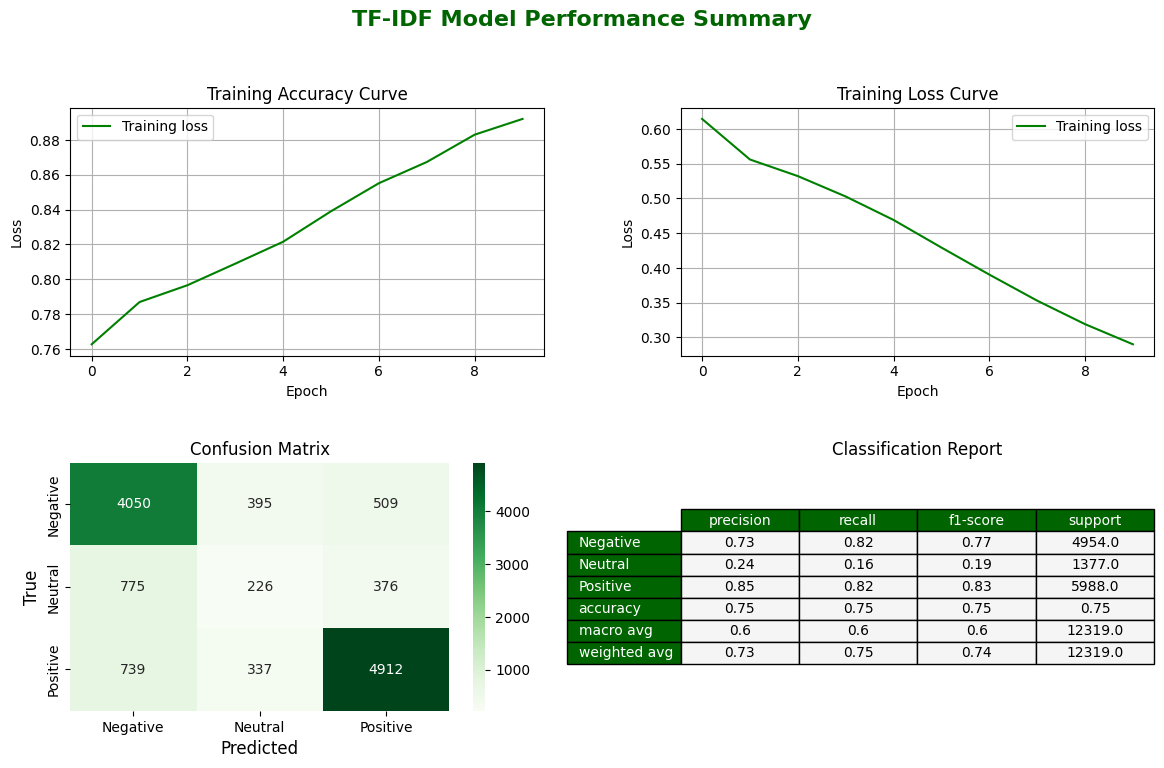

In [ ]:
model_evaluation(model_tfidf, test_loader_tfidf, loss_history_tfidf, accuracy_history_tfidf, "TF-IDF")

### Word2Vec Embedding Model

In [ ]:
# Build model
model_word2vec, test_loader_word2vec, loss_history_word2vec, accuracy_history_word2vec = embedding_model(
    X_word2vec, df_spotify['Sentiment_Label'].values)

Epoch 1/10 | Loss: 0.6398 | Accuracy: 0.7574
Epoch 2/10 | Loss: 0.6160 | Accuracy: 0.7685
Epoch 3/10 | Loss: 0.6094 | Accuracy: 0.7699
Epoch 4/10 | Loss: 0.6046 | Accuracy: 0.7713
Epoch 5/10 | Loss: 0.6012 | Accuracy: 0.7721
Epoch 6/10 | Loss: 0.5973 | Accuracy: 0.7745
Epoch 7/10 | Loss: 0.5964 | Accuracy: 0.7752
Epoch 8/10 | Loss: 0.5953 | Accuracy: 0.7751
Epoch 9/10 | Loss: 0.5921 | Accuracy: 0.7767
Epoch 10/10 | Loss: 0.5908 | Accuracy: 0.7762


#### Model Summary

In [ ]:
model_summary(model_word2vec)

MLP(
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=100, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

Total params: 59,139
Trainable params: 59,139


#### Model Evaluation

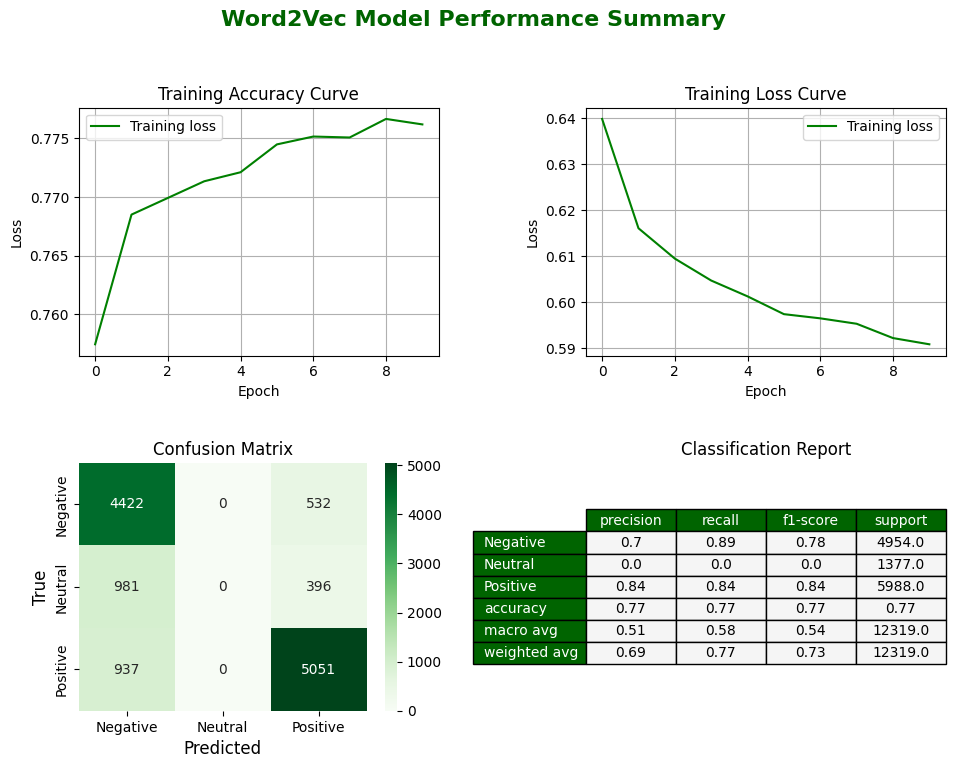

In [ ]:
model_evaluation(model_word2vec, test_loader_word2vec, loss_history_word2vec, accuracy_history_word2vec, "Word2Vec")

### BERT Embedding Model

In [ ]:
# Build model
model_bert, test_loader_bert, loss_history_bert, accuracy_history_bert = embedding_model(
    X_bert, df_spotify['Sentiment_Label'].values)

Epoch 1/10 | Loss: 0.6705 | Accuracy: 0.7424
Epoch 2/10 | Loss: 0.6419 | Accuracy: 0.7558
Epoch 3/10 | Loss: 0.6318 | Accuracy: 0.7589
Epoch 4/10 | Loss: 0.6272 | Accuracy: 0.7599
Epoch 5/10 | Loss: 0.6225 | Accuracy: 0.7632
Epoch 6/10 | Loss: 0.6187 | Accuracy: 0.7650
Epoch 7/10 | Loss: 0.6140 | Accuracy: 0.7660
Epoch 8/10 | Loss: 0.6117 | Accuracy: 0.7681
Epoch 9/10 | Loss: 0.6091 | Accuracy: 0.7690
Epoch 10/10 | Loss: 0.6067 | Accuracy: 0.7704


#### Model Summary

In [ ]:
model_summary(model_bert)

MLP(
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=768, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

Total params: 230,147
Trainable params: 230,147


#### Model Evaluation

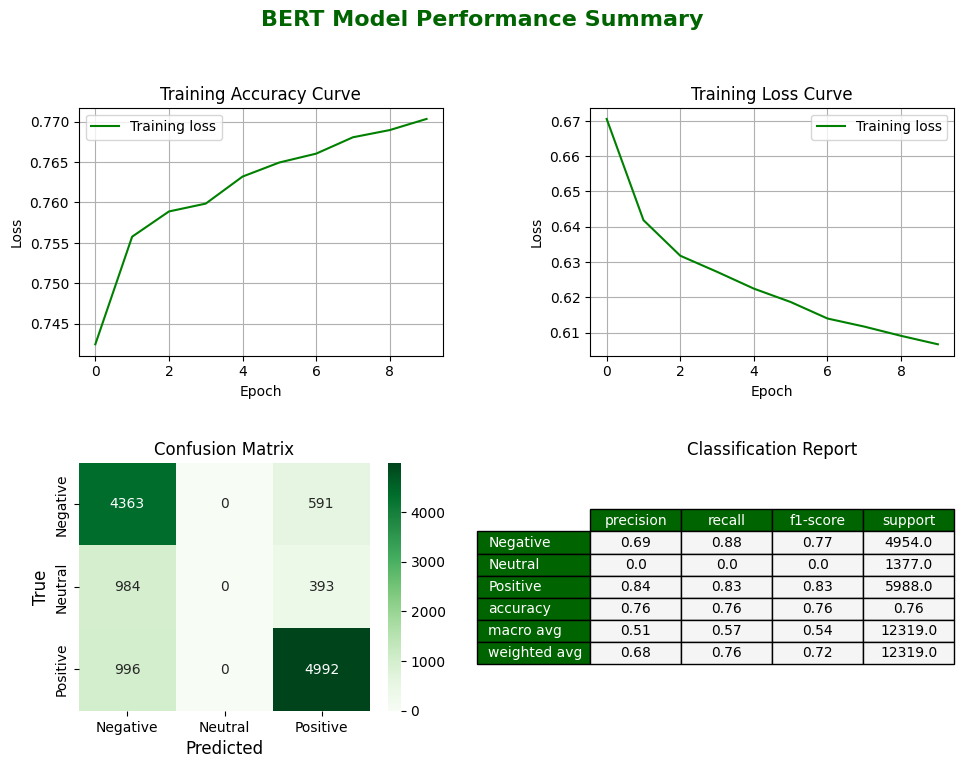

In [ ]:
model_evaluation(model_bert, test_loader_bert, loss_history_bert, accuracy_history_bert, "BERT")

## Predictions

In [ ]:
def preprocess_review(text):
    # 1. Tokenize
    tokens = word_tokenize(text)

    # 2. Lemmatize & lowercase
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens]

    # 3. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 4. Remove hashtags
    tokens = remove_hashtags(tokens)

    # 5. Remove non-alphanumeric tokens (punctuation, etc.)
    tokens = remove_non_alphanumeric_tokens(tokens)

    # 6. Remove non-ASCII tokens
    tokens = remove_non_ascii_tokens(tokens)

    # 7. Remove slang
    tokens = remove_slang(tokens)

    # 8. Remove unwanted (alphanumeric-mixed) tokens
    tokens = remove_unwanted_tokens(tokens)

    return tokens

In [ ]:
# Pick an random review from the cleaned data
positive_review = "I absolutely love this app, it’s so smooth and fast!"
negative_review = "Spotify's update ruined everything!!!😠 #trash"

In [ ]:
def predict_review(review, embedding_type,label_map={0: 'Negative', 1: 'Neutral', 2: 'Positive'}):
    # Preprocess the review
    tokens = preprocess_review(review)
    clean_text = ' '.join(tokens)

    if embedding_type=='tfidf':
        vec = tfidf_vectorizer.transform([clean_text]) \
                             .toarray().astype(np.float32)
    elif embedding_type=='word2vec':
        valid = [t for t in tokens if t in w2v_embedding.wv]
        vec = (np.mean([w2v_embedding.wv[t] for t in valid],axis=0)
               if valid else np.zeros(w2v_embedding.vector_size))
        vec = vec.astype(np.float32).reshape(1,-1)
    elif embedding_type=='bert':
        vec = get_bert_embedding(clean_text).astype(np.float32).reshape(1,-1)
    else:
        raise ValueError(embedding_type)

    tensor = torch.tensor(vec, dtype=torch.float32, device=device)
    model = {
      'tfidf':   model_tfidf,
      'word2vec':model_word2vec,
      'bert':    model_bert
    }[embedding_type]
    model.eval()
    with torch.no_grad():
        out = model(tensor)
        pred = out.argmax(dim=1).item()

    return label_map[pred]

In [ ]:
# TF-IDF
print(predict_review(
    positive_review,
    embedding_type='tfidf',
))

# Word2Vec
print(predict_review(
    positive_review,
    embedding_type='word2vec',
))

# BERT
print(predict_review(
    positive_review,
    embedding_type='bert',
))

Positive
Positive


TypeError: MLP.forward() got an unexpected keyword argument 'input_ids'